In [316]:
import matplotlib.pyplot as plt
import pandas as pd
import math
from typing import Literal
import numpy as np
import os
import sys
sys.path.append("../") # Where to find utilssphering
import utilssphering
import seaborn as sns

In [320]:
match_rep_df = pd.read_csv("../checkpoints/match_rep_df.csv")

match_rep_df = match_rep_df[match_rep_df["sphering"] == True]

match_rep_df

,Vendor,Batch,Plate_Map_Name,Assay_Plate_Barcode,Modality,Images_per_well,Sites-SubSampled,Binning,Magnification,Number_of_channels,...,Size_MB_std,sphering,value_95_replicating,Percent_Replicating,channel_names,brightfield_z_plane_used,feature_channels_found,Percent_Matching,value_95_matching,cell_count
0,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Widefield,4,NaN,1,10,6,...,0.000144,True,0.191908,60.000000,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",23.255814,0.288099,2014937
2,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,4,NaN,1,10,6,...,0.000183,True,0.269617,62.222222,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",18.604651,0.398249,2413350
4,MolDev,Scope1_MolDev_10X_4siteZ,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crestz,Confocal,4,NaN,1,10,6,...,0.000142,True,0.205121,66.666667,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",23.255814,0.363114,2381443
6,MolDev,Scope1_MolDev_20X_4site,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_20XPA_Crestz,Confocal,4,NaN,1,20,6,...,0.000114,True,0.182630,57.777778,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",18.604651,0.279178,527841
8,MolDev,Scope1_MolDev_20X_9site,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_9site_20XPA,Widefield,9,NaN,1,20,6,...,0.000153,True,0.184205,67.777778,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",23.255814,0.291127,1101611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_5Ch,JUMP-MOA_compound_platemap,BRO0117056_20x,Confocal,9,4.0,1,20,5,...,0.000044,True,0.174914,57.777778,"AGP, DNA, ER, Mito, RNA",NaN,"AGP, DNA, ER, Mito, RNA",23.255814,0.244983,544244
354,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_5Ch_12Z,JUMP-MOA_compound_platemap,BRO0117056_20xb,Confocal,9,4.0,1,20,5,...,0.000044,True,0.157136,60.000000,"AGP, DNA, ER, Mito, RNA",NaN,"AGP, DNA, ER, Mito, RNA",20.930233,0.227059,543826
356,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO0117059_20X,Confocal,9,4.0,1,20,6,...,0.000583,True,0.179268,58.888889,"AGP, BrightField, DNA, ER, Mito, RNA",Z08,"AGP, BrightField, DNA, ER, Mito, RNA",20.930233,0.253483,489099
358,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,4.0,1,20,6,...,0.000014,True,0.139090,56.666667,"AGP, BrightField, DNA, ER, Mito, RNA",Z17,"AGP, BrightField, DNA, ER, Mito, RNA",18.604651,0.193171,452567


In [321]:
def calculate_pval_proportion(dataframe: pd.DataFrame, pval_threshold: float = 0.05, ref_non_rep: Literal["rep", "non_rep"] = "non_rep"):
    """For a given DataFrame, calculate the proportion above the pvalue
    threshold"""
    # mean_ap_col = f"sim_retrieval_average_precision_{ref_non_rep}_i_mean_i"
    mean_ap_pval_col = f"sim_retrieval_average_precision_{ref_non_rep}_i_nlog10qvalue_mean_i"

    pval_threshold = -math.log10(pval_threshold)

    return (dataframe[mean_ap_pval_col] > pval_threshold).sum() / len(dataframe[mean_ap_pval_col])

def get_evalzoo_metrics(row, evalzoo_dir: str = "results/results", ref_non_rep: Literal["rep", "non_rep"] = "non_rep"):
    evalzoo_metric_path = os.path.join(evalzoo_dir, row["Batch"]+"_"+ref_non_rep, f"metrics_level_1_{ref_non_rep}.parquet")
    evalzoo_metric_df = pd.read_parquet(evalzoo_metric_path)
    # Subset for the specific plate of a given row
    evalzoo_metric_df = evalzoo_metric_df[evalzoo_metric_df["Metadata_Plate"] == row["Assay_Plate_Barcode"]]

    return calculate_pval_proportion(evalzoo_metric_df, pval_threshold=0.05, ref_non_rep=ref_non_rep)


match_rep_df["ref_score"] = match_rep_df.apply(get_evalzoo_metrics, ref_non_rep="ref", axis=1) * 100
match_rep_df["non_rep_score"] = match_rep_df.apply(get_evalzoo_metrics, ref_non_rep="non_rep", axis=1) * 100

            

In [323]:
match_rep_df.to_csv("../checkpoints/match_rep_df_with_evalzoo_proportions.csv", index=False)
match_rep_df

,Vendor,Batch,Plate_Map_Name,Assay_Plate_Barcode,Modality,Images_per_well,Sites-SubSampled,Binning,Magnification,Number_of_channels,...,value_95_replicating,Percent_Replicating,channel_names,brightfield_z_plane_used,feature_channels_found,Percent_Matching,value_95_matching,cell_count,ref_score,non_rep_score
0,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Widefield,4,NaN,1,10,6,...,0.191908,60.000000,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",23.255814,0.288099,2014937,50.000000,0.000000
2,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,4,NaN,1,10,6,...,0.269617,62.222222,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",18.604651,0.398249,2413350,50.000000,0.000000
4,MolDev,Scope1_MolDev_10X_4siteZ,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crestz,Confocal,4,NaN,1,10,6,...,0.205121,66.666667,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",23.255814,0.363114,2381443,56.666667,18.604651
6,MolDev,Scope1_MolDev_20X_4site,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_20XPA_Crestz,Confocal,4,NaN,1,20,6,...,0.182630,57.777778,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",18.604651,0.279178,527841,44.444444,9.302326
8,MolDev,Scope1_MolDev_20X_9site,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_9site_20XPA,Widefield,9,NaN,1,20,6,...,0.184205,67.777778,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",23.255814,0.291127,1101611,56.666667,21.276596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_5Ch,JUMP-MOA_compound_platemap,BRO0117056_20x,Confocal,9,4.0,1,20,5,...,0.174914,57.777778,"AGP, DNA, ER, Mito, RNA",NaN,"AGP, DNA, ER, Mito, RNA",23.255814,0.244983,544244,37.777778,6.382979
354,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_5Ch_12Z,JUMP-MOA_compound_platemap,BRO0117056_20xb,Confocal,9,4.0,1,20,5,...,0.157136,60.000000,"AGP, DNA, ER, Mito, RNA",NaN,"AGP, DNA, ER, Mito, RNA",20.930233,0.227059,543826,44.444444,13.953488
356,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO0117059_20X,Confocal,9,4.0,1,20,6,...,0.179268,58.888889,"AGP, BrightField, DNA, ER, Mito, RNA",Z08,"AGP, BrightField, DNA, ER, Mito, RNA",20.930233,0.253483,489099,30.000000,9.302326
358,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,4.0,1,20,6,...,0.139090,56.666667,"AGP, BrightField, DNA, ER, Mito, RNA",Z17,"AGP, BrightField, DNA, ER, Mito, RNA",18.604651,0.193171,452567,27.777778,9.302326


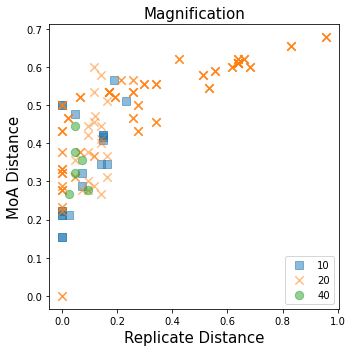

In [13]:
# A

group = "Magnification"

df_subset = match_rep_df[
                        (match_rep_df["sphering"] == True) #&
                        # (~match_rep_df["Batch"].str.contains("siteSub")) 
                        ]

group_df = utilssphering.find_group_avg_df(df_subset, group)

fig, ax = plt.subplots(figsize=(5,5))

utilssphering.group_plot(
    df_subset, 
    x="non_rep_score", 
    y="ref_score", 
    group=group, 
    fig=fig, 
    ax_=ax, 
    legend=True,
    legend_location="lower right",
    alpha=0.5,
    use_markers=True,
    s=70,
    # x_lim=[16,26],
    # y_lim=[38,70],
    xlabel="Replicate Distance",
    ylabel="MoA Distance"
    )

# fig.savefig("(A)-rep-vs-match-mag.png", dpi=300)


<AxesSubplot:xlabel='Magnification', ylabel='ref_score'>

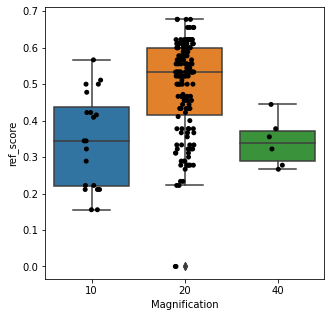

In [300]:
group = "Magnification"

df_subset = match_rep_df[
                        (match_rep_df["sphering"] == True) #&
                        # (~match_rep_df["Batch"].str.contains("siteSub")) 
                        ]

group_df = utilssphering.find_group_avg_df(df_subset, group)

fig, ax = plt.subplots(figsize=(5,5))

sns.boxplot(data=df_subset, x=group, y="ref_score")
sns.stripplot(data=df_subset, x=group, y="ref_score", color="black")


In [275]:
match_rep_df.columns

Index(['Vendor', 'Batch', 'Plate_Map_Name', 'Assay_Plate_Barcode', 'Modality',
       'Images_per_well', 'Sites-SubSampled', 'Binning', 'Magnification',
       'Number_of_channels', 'z_plane', 'BF_Zplanes', 'aperture',
       'dry-immersion', 'vs-brightfield', 'simultaneous-excitation', 'sites',
       'Size_MB', 'Size_MB_std', 'sphering', 'value_95_replicating',
       'Percent_Replicating', 'channel_names', 'brightfield_z_plane_used',
       'feature_channels_found', 'Percent_Matching', 'value_95_matching',
       'cell_count', 'ref_score', 'non_rep_score'],
      dtype='object')

<AxesSubplot:xlabel='Binning', ylabel='ref_score'>

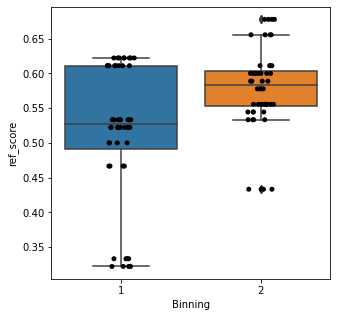

In [296]:
group = "Binning"

df_subset = match_rep_df[
                        (match_rep_df["sphering"] == True) &
                        (match_rep_df["Vendor"] == "PE")
                        # (~match_rep_df["Batch"].str.contains("siteSub")) 
                        ]

group_df = utilssphering.find_group_avg_df(df_subset, group)

fig, ax = plt.subplots(figsize=(5,5))

sns.boxplot(data=df_subset, x=group, y="ref_score")
sns.stripplot(data=df_subset, x=group, y="ref_score", color="black")

<AxesSubplot:xlabel='z_plane', ylabel='ref_score'>

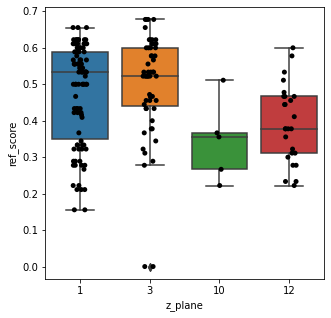

In [297]:
group = "z_plane"

df_subset = match_rep_df[
                        (match_rep_df["sphering"] == True) #&
                        # (~match_rep_df["Batch"].str.contains("siteSub")) 
                        ]

group_df = utilssphering.find_group_avg_df(df_subset, group)

fig, ax = plt.subplots(figsize=(5,5))

sns.boxplot(data=df_subset, x=group, y="ref_score")
sns.stripplot(data=df_subset, x=group, y="ref_score", color="black")

<AxesSubplot:xlabel='Number_of_channels', ylabel='ref_score'>

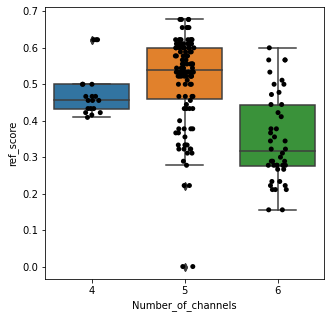

In [298]:
group = "Number_of_channels"

df_subset = match_rep_df[
                        (match_rep_df["sphering"] == True) #&
                        # (~match_rep_df["Batch"].str.contains("siteSub")) 
                        ]

group_df = utilssphering.find_group_avg_df(df_subset, group)

fig, ax = plt.subplots(figsize=(5,5))

sns.boxplot(data=df_subset, x=group, y="ref_score")
sns.stripplot(data=df_subset, x=group, y="ref_score", color="black")

<AxesSubplot:xlabel='sites', ylabel='ref_score'>

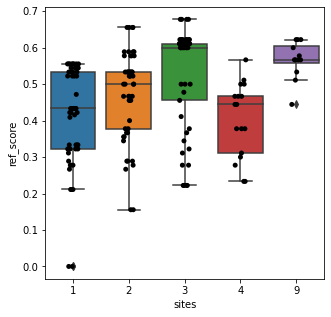

In [299]:
group = "sites"

df_subset = match_rep_df[
                        (match_rep_df["sphering"] == True) #&
                        # (~match_rep_df["Batch"].str.contains("siteSub")) 
                        ]

group_df = utilssphering.find_group_avg_df(df_subset, group)

fig, ax = plt.subplots(figsize=(5,5))

sns.boxplot(data=df_subset, x=group, y="ref_score")
sns.stripplot(data=df_subset, x=group, y="ref_score", color="black")

In [271]:
df_subset.columns

Index(['Vendor', 'Batch', 'Plate_Map_Name', 'Assay_Plate_Barcode', 'Modality',
       'Images_per_well', 'Sites-SubSampled', 'Binning', 'Magnification',
       'Number_of_channels', 'z_plane', 'BF_Zplanes', 'aperture',
       'dry-immersion', 'vs-brightfield', 'simultaneous-excitation', 'sites',
       'Size_MB', 'Size_MB_std', 'sphering', 'value_95_replicating',
       'Percent_Replicating', 'channel_names', 'brightfield_z_plane_used',
       'feature_channels_found', 'Percent_Matching', 'value_95_matching',
       'cell_count'],
      dtype='object')

In [ ]:
# Plotting on non-aggregated distributions

CP_Broad_Phenix_C_BIN1_P1


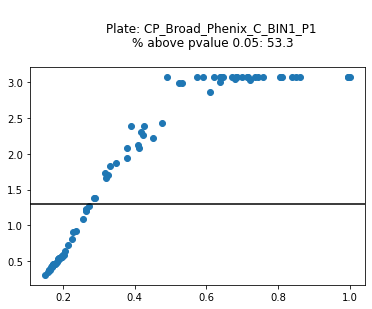

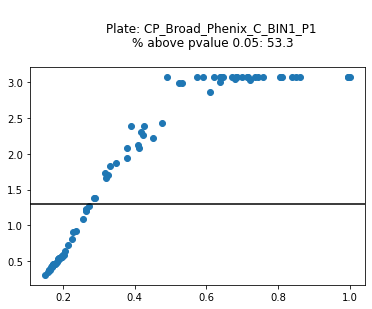

In [24]:


def plot_evalzoo_plate(dataframe: pd.DataFrame, ref_non_rep: Literal["rep", "non_rep"] = "non_rep", plot_proportion: bool = True, pval_threshold: float = 0.05):
    mean_ap_col = f"sim_retrieval_average_precision_{ref_non_rep}_i_mean_i"
    mean_ap_pval_col = f"sim_retrieval_average_precision_{ref_non_rep}_i_nlog10qvalue_mean_i"

    pval_proportion = calculate_pval_proportion(dataframe, pval_threshold=pval_threshold, ref_non_rep=ref_non_rep) * 100

    fig, ax = plt.subplots()

    ax.scatter(dataframe[mean_ap_col], dataframe[mean_ap_pval_col])
    ax.axhline(y=-math.log10(pval_threshold), color="black")
    ax.set_title(f"""
        Plate: {dataframe["Metadata_Plate"][0]} 
        % above pvalue 0.05: {round(pval_proportion, 1)}
    """)
    fig.set_facecolor("white")

    return fig

# df = pd.read_parquet("/Users/ctromans/Desktop/input/results/results/5673b72b/metrics_level_1_non_rep.parquet")
df = pd.read_parquet("/Users/ctromans/Desktop/input/results/results/8224e52e/metrics_level_1_ref.parquet")

plate = df["Metadata_Plate"].tolist()[0]

print(plate)

sub_df = df[df["Metadata_Plate"] == plate]

calculate_pval_proportion(sub_df, ref_non_rep="ref")

plot_evalzoo_plate(sub_df, ref_non_rep="ref")

For each batch we have a non_rep and a ref parquet file. Within this file exists the data for multiple plates. Now, we want to try and combine all of this data into one parquet file, across all vendors. To differentiate between ref and non_ref, we'll add a new column to the dataframe: metric_type, which will contain the levels "ref" and "non_rep". To the same dataframe we will also add a column for the batch and the vendor, that will allow us to subset later

1. Iterate through match_rep_df and load the corresponding ref and non_rep metrics
2. Combine metrics into a new dataframe with the vendor, batch, and metric_type columns
3. Repeat for all rows



In [23]:
t = pd.read_parquet("results/results/Scope1_MolDev_10X_ref/")

# t.columns = [str(col) + "_TEST" for col in t.columns if "sim" in col]


t.rename(lambda x: x+"_TEST" if "sim_" in x else x, axis=1)

,Metadata_pert_iname,Metadata_reference_or_other,Metadata_Plate,sim_scaled_mean_ref_i_mean_i_TEST,sim_scaled_mean_ref_i_median_i_TEST,sim_scaled_median_ref_i_mean_i_TEST,sim_scaled_median_ref_i_median_i_TEST,sim_ranked_relrank_mean_ref_i_mean_i_TEST,sim_ranked_relrank_mean_ref_i_median_i_TEST,sim_ranked_relrank_median_ref_i_mean_i_TEST,...,sim_stat_signal_n_ref_i_median_i_TEST,sim_stat_background_n_ref_i_mean_i_TEST,sim_stat_background_n_ref_i_median_i_TEST,sim_retrieval_average_precision_ref_i_mean_i_TEST,sim_retrieval_average_precision_ref_i_median_i_TEST,sim_retrieval_r_precision_ref_i_mean_i_TEST,sim_retrieval_r_precision_ref_i_median_i_TEST,sim_retrieval_average_precision_ref_i_nlog10pvalue_mean_i_TEST,sim_retrieval_average_precision_ref_i_nlog10pvalue_median_i_TEST,sim_retrieval_average_precision_ref_i_nlog10qvalue_mean_i_TEST
0,A-366,pert,Plate2_PCO_6ch_4site_10XPA,0.017355,0.034813,-0.152331,-0.183784,0.505952,0.531250,0.533854,...,7.0,48.0,48.0,0.164346,0.153485,0.107143,0.142857,0.333687,0.277463,0.308864
1,A-366,pert,Plate3_PCO_6ch_4site_10XPA_Crest,0.017355,0.034813,-0.152331,-0.183784,0.505952,0.531250,0.533854,...,7.0,48.0,48.0,0.164346,0.153485,0.107143,0.142857,0.333687,0.277463,0.308864
2,ABT-737,pert,Plate2_PCO_6ch_4site_10XPA,1.550364,1.901986,1.559669,1.654185,0.158854,0.126488,0.101562,...,7.0,48.0,48.0,0.554780,0.578962,0.428571,0.571429,2.727806,3.008908,2.293433
3,ABT-737,pert,Plate3_PCO_6ch_4site_10XPA_Crest,1.550364,1.901986,1.559669,1.654185,0.158854,0.126488,0.101562,...,7.0,48.0,48.0,0.554780,0.578962,0.428571,0.571429,2.727806,3.008908,2.293433
4,AMG-925,pert,Plate2_PCO_6ch_4site_10XPA,2.544456,2.651249,2.358491,2.587136,0.101935,0.093750,0.088542,...,7.0,48.0,48.0,0.707481,0.768701,0.589286,0.714286,3.290924,4.000043,2.591954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,skepinone-l,pert,Plate3_PCO_6ch_4site_10XPA_Crest,1.275971,1.547769,1.483524,1.929239,0.191964,0.183036,0.119792,...,7.0,48.0,48.0,0.505619,0.486557,0.392857,0.571429,2.572278,2.322893,2.177323
176,valrubicin,pert,Plate2_PCO_6ch_4site_10XPA,4.724061,5.607561,4.530161,5.252351,0.049107,0.020833,0.059896,...,7.0,48.0,48.0,0.860989,1.000000,0.767857,1.000000,3.825301,4.000043,2.736706
177,valrubicin,pert,Plate3_PCO_6ch_4site_10XPA_Crest,4.724061,5.607561,4.530161,5.252351,0.049107,0.020833,0.059896,...,7.0,48.0,48.0,0.860989,1.000000,0.767857,1.000000,3.825301,4.000043,2.736706
178,veliparib,pert,Plate2_PCO_6ch_4site_10XPA,0.376637,0.406893,0.043987,-0.125647,0.406622,0.392857,0.375000,...,7.0,48.0,48.0,0.239478,0.237570,0.178571,0.142857,0.736744,0.703664,0.588681


In [314]:
def combine_evalzoo_metrics(match_rep_df: pd.DataFrame, evalzoo_dir: str = "results/results"):
    # Add Batch and Metadata_Plate since we need to check the presence of a
    # string in them later, and you can't check them if they don't exist
    output_df = pd.DataFrame({"Batch": [], "Metadata_Plate": []})
    for ind, row in match_rep_df.iterrows():
        # Need to do some check that this row has not already been processed (so
        # we don't add it twice)
        if not (row["Batch"] in output_df["Batch"].values and row["Assay_Plate_Barcode"] in output_df["Metadata_Plate"].values):
            ref_metric_path = os.path.join(evalzoo_dir, row["Batch"]+"_ref", f"metrics_level_1_ref.parquet")
            non_rep_metric_path = os.path.join(evalzoo_dir, row["Batch"]+"_non_rep", f"metrics_level_1_non_rep.parquet")

            ref_metric_df = pd.read_parquet(ref_metric_path)
            non_rep_metric_df = pd.read_parquet(non_rep_metric_path)

            # Since we are going to use the metric_type to differentiate between ref
            # and non_rep, remove this information from the feature names
            # ref_metric_df = ref_metric_df.rename(lambda x: x + "_ref" if "sim_" in x else x, axis=1)
            # non_rep_metric_df = non_rep_metric_df.rename(lambda x: x + "_non_rep" if "sim_" in x else x, axis=1)

            ref_metric_df = ref_metric_df.rename(lambda x: x.replace("_ref", "") if "sim_" in x else x, axis=1)
            non_rep_metric_df = non_rep_metric_df.rename(lambda x: x.replace("_non_rep", "") if "sim_" in x else x, axis=1)

            # Add cols
            (
                ref_metric_df["Vendor"], 
                ref_metric_df["Batch"], 
                ref_metric_df["Magnification"], 
                ref_metric_df["Binning"], 
                ref_metric_df["z_plane"], 
                ref_metric_df["metric_type"]
                ) = (
                row["Vendor"], 
                row["Batch"], 
                row["Magnification"], 
                row["Binning"], 
                row["z_plane"], 
                "ref"
            )

            (
                non_rep_metric_df["Vendor"], 
                non_rep_metric_df["Batch"],
                non_rep_metric_df["Magnification"], 
                non_rep_metric_df["Binning"], 
                non_rep_metric_df["z_plane"], 
                non_rep_metric_df["metric_type"]
                ) = (
                row["Vendor"], 
                row["Batch"], 
                row["Magnification"], 
                row["Binning"], 
                row["z_plane"], 
                "non_rep"
                )
            
            # Cast some columns to int
            ref_metric_df["Magnification"] = ref_metric_df["Magnification"].astype("Int64")
            ref_metric_df["Binning"] = ref_metric_df["Binning"].astype("Int64")
            ref_metric_df["z_plane"] = ref_metric_df["z_plane"].astype("Int64")

            non_rep_metric_df["Magnification"] = non_rep_metric_df["Magnification"].astype("Int64")
            non_rep_metric_df["Binning"] = non_rep_metric_df["Binning"].astype("Int64")
            non_rep_metric_df["z_plane"] = non_rep_metric_df["z_plane"].astype("Int64")


            output_df = pd.concat([output_df, ref_metric_df, non_rep_metric_df], axis=0)

    return output_df

evalzoo_combined = combine_evalzoo_metrics(match_rep_df)
evalzoo_combined

/var/folders/rw/691cc6h16f9cfxlh9g6bpq400000gq/T/ipykernel_90278/4187219851.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if not (row["Batch"] in output_df["Batch"].values and row["Assay_Plate_Barcode"] in output_df["Metadata_Plate"].values):


,Batch,Metadata_Plate,Metadata_pert_iname,Metadata_reference_or_other,sim_scaled_mean_i_mean_i,sim_scaled_mean_i_median_i,sim_scaled_median_i_mean_i,sim_scaled_median_i_median_i,sim_ranked_relrank_mean_i_mean_i,sim_ranked_relrank_mean_i_median_i,...,sim_retrieval_r_precision_i_median_i,sim_retrieval_average_precision_i_nlog10pvalue_mean_i,sim_retrieval_average_precision_i_nlog10pvalue_median_i,sim_retrieval_average_precision_i_nlog10qvalue_mean_i,Vendor,Magnification,Binning,z_plane,metric_type,Metadata_moa
0,Scope1_MolDev_10X,Plate2_PCO_6ch_4site_10XPA,A-366,pert,0.017355,0.034813,-0.152331,-0.183784,0.505952,0.531250,...,0.142857,0.333687,0.277463,0.308864,MolDev,10,1,1,ref,NaN
1,Scope1_MolDev_10X,Plate3_PCO_6ch_4site_10XPA_Crest,A-366,pert,0.017355,0.034813,-0.152331,-0.183784,0.505952,0.531250,...,0.142857,0.333687,0.277463,0.308864,MolDev,10,1,1,ref,NaN
2,Scope1_MolDev_10X,Plate2_PCO_6ch_4site_10XPA,ABT-737,pert,1.550364,1.901986,1.559669,1.654185,0.158854,0.126488,...,0.571429,2.727806,3.008908,2.293433,MolDev,10,1,1,ref,NaN
3,Scope1_MolDev_10X,Plate3_PCO_6ch_4site_10XPA_Crest,ABT-737,pert,1.550364,1.901986,1.559669,1.654185,0.158854,0.126488,...,0.571429,2.727806,3.008908,2.293433,MolDev,10,1,1,ref,NaN
4,Scope1_MolDev_10X,Plate2_PCO_6ch_4site_10XPA,AMG-925,pert,2.544456,2.651249,2.358491,2.587136,0.101935,0.093750,...,0.714286,3.290924,4.000043,2.591954,MolDev,10,1,1,ref,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,4siteSubSample_Scope1_Yokogawa_US_40X_BRO0117059,BRO0117059_40x,NaN,pert,0.017382,0.017382,0.017382,0.017382,0.426136,0.426136,...,0.000000,0.406356,0.406356,0.126677,Yokogawa_US,40,1,12,non_rep,pyruvate dehydrogenase kinase inhibitor
39,4siteSubSample_Scope1_Yokogawa_US_40X_BRO0117059,BRO0117059_40x,NaN,pert,-0.232787,-0.232787,-0.232787,-0.232787,0.585227,0.585227,...,0.000000,0.308816,0.308816,0.090321,Yokogawa_US,40,1,12,non_rep,smoothened receptor agonist
40,4siteSubSample_Scope1_Yokogawa_US_40X_BRO0117059,BRO0117059_40x,NaN,pert,-1.010539,-1.010539,-1.010539,-1.010539,0.869318,0.869318,...,0.000000,0.087009,0.087009,0.055154,Yokogawa_US,40,1,12,non_rep,tricyclic antidepressant
41,4siteSubSample_Scope1_Yokogawa_US_40X_BRO0117059,BRO0117059_40x,NaN,pert,-1.011224,-1.011224,-1.011224,-1.011224,0.710227,0.710227,...,0.000000,0.212973,0.212973,0.063732,Yokogawa_US,40,1,12,non_rep,tumor necrosis factor production inhibitor


In [315]:
evalzoo_combined.to_parquet("evalzoo_metrics_combined.paraquet", index=False)
evalzoo_combined = pd.read_parquet("evalzoo_metrics_combined.paraquet")
evalzoo_combined

,Batch,Metadata_Plate,Metadata_pert_iname,Metadata_reference_or_other,sim_scaled_mean_i_mean_i,sim_scaled_mean_i_median_i,sim_scaled_median_i_mean_i,sim_scaled_median_i_median_i,sim_ranked_relrank_mean_i_mean_i,sim_ranked_relrank_mean_i_median_i,...,sim_retrieval_r_precision_i_median_i,sim_retrieval_average_precision_i_nlog10pvalue_mean_i,sim_retrieval_average_precision_i_nlog10pvalue_median_i,sim_retrieval_average_precision_i_nlog10qvalue_mean_i,Vendor,Magnification,Binning,z_plane,metric_type,Metadata_moa
0,Scope1_MolDev_10X,Plate2_PCO_6ch_4site_10XPA,A-366,pert,0.017355,0.034813,-0.152331,-0.183784,0.505952,0.531250,...,0.142857,0.333687,0.277463,0.308864,MolDev,10,1,1,ref,None
1,Scope1_MolDev_10X,Plate3_PCO_6ch_4site_10XPA_Crest,A-366,pert,0.017355,0.034813,-0.152331,-0.183784,0.505952,0.531250,...,0.142857,0.333687,0.277463,0.308864,MolDev,10,1,1,ref,None
2,Scope1_MolDev_10X,Plate2_PCO_6ch_4site_10XPA,ABT-737,pert,1.550364,1.901986,1.559669,1.654185,0.158854,0.126488,...,0.571429,2.727806,3.008908,2.293433,MolDev,10,1,1,ref,None
3,Scope1_MolDev_10X,Plate3_PCO_6ch_4site_10XPA_Crest,ABT-737,pert,1.550364,1.901986,1.559669,1.654185,0.158854,0.126488,...,0.571429,2.727806,3.008908,2.293433,MolDev,10,1,1,ref,None
4,Scope1_MolDev_10X,Plate2_PCO_6ch_4site_10XPA,AMG-925,pert,2.544456,2.651249,2.358491,2.587136,0.101935,0.093750,...,0.714286,3.290924,4.000043,2.591954,MolDev,10,1,1,ref,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24635,4siteSubSample_Scope1_Yokogawa_US_40X_BRO0117059,BRO0117059_40x,None,pert,0.017382,0.017382,0.017382,0.017382,0.426136,0.426136,...,0.000000,0.406356,0.406356,0.126677,Yokogawa_US,40,1,12,non_rep,pyruvate dehydrogenase kinase inhibitor
24636,4siteSubSample_Scope1_Yokogawa_US_40X_BRO0117059,BRO0117059_40x,None,pert,-0.232787,-0.232787,-0.232787,-0.232787,0.585227,0.585227,...,0.000000,0.308816,0.308816,0.090321,Yokogawa_US,40,1,12,non_rep,smoothened receptor agonist
24637,4siteSubSample_Scope1_Yokogawa_US_40X_BRO0117059,BRO0117059_40x,None,pert,-1.010539,-1.010539,-1.010539,-1.010539,0.869318,0.869318,...,0.000000,0.087009,0.087009,0.055154,Yokogawa_US,40,1,12,non_rep,tricyclic antidepressant
24638,4siteSubSample_Scope1_Yokogawa_US_40X_BRO0117059,BRO0117059_40x,None,pert,-1.011224,-1.011224,-1.011224,-1.011224,0.710227,0.710227,...,0.000000,0.212973,0.212973,0.063732,Yokogawa_US,40,1,12,non_rep,tumor necrosis factor production inhibitor


['CP_Broad_Phenix_C_BIN1_1Plane_P1' 'CP_Broad_Phenix_C_BIN1_1Plane_P2'
 'CP_Broad_Phenix_C_BIN1_1Plane_P3' 'CP_Broad_Phenix_C_BIN1_1Plane_P4'
 'CP_Broad_Phenix_C_BIN1_P1' 'CP_Broad_Phenix_C_BIN1_P2'
 'CP_Broad_Phenix_C_BIN1_P3' 'CP_Broad_Phenix_C_BIN1_P4'
 'CP_Broad_Phenix_NC_BIN1_1Plane_P1' 'CP_Broad_Phenix_NC_BIN1_1Plane_P2'
 'CP_Broad_Phenix_NC_BIN1_1Plane_P3' 'CP_Broad_Phenix_NC_BIN1_1Plane_P4'
 'CP_Broad_Phenix_NC_BIN1_P1' 'CP_Broad_Phenix_NC_BIN1_P2'
 'CP_Broad_Phenix_NC_BIN1_P3' 'CP_Broad_Phenix_NC_BIN1_P4'
 'CPBroadPhenixC1PlaneP1' 'CPBroadPhenixC1PlaneP2'
 'CPBroadPhenixC1PlaneP3' 'CPBroadPhenixC1PlaneP4' 'CPBroadPhenixCP1'
 'CPBroadPhenixCP2' 'CPBroadPhenixCP3' 'CPBroadPhenixCP4'
 'CPBroadPhenixNC1PlaneP1' 'CPBroadPhenixNC1PlaneP2'
 'CPBroadPhenixNC1PlaneP3' 'CPBroadPhenixNC1PlaneP4' 'CPBroadPhenixNCP1'
 'CPBroadPhenixNCP2' 'CPBroadPhenixNCP3' 'CPBroadPhenixNCP4']


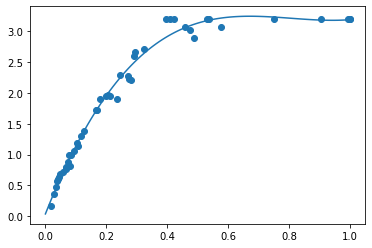

In [127]:
vendor_subset = evalzoo_combined[evalzoo_combined["Vendor"] == "PE"]

print(vendor_subset["Metadata_Plate"].unique())

plot_df = vendor_subset[
    (vendor_subset["Metadata_Plate"] == "CP_Broad_Phenix_C_BIN1_1Plane_P1") & 
    (~vendor_subset["Batch"].str.contains("siteSub")) & 
    (vendor_subset["metric_type"] == "non_rep")
    ]

fig, ax = plt.subplots()

x = plot_df["sim_retrieval_average_precision_i_mean_i"]
y = plot_df["sim_retrieval_average_precision_i_nlog10qvalue_mean_i"]

mymodel = np.poly1d(np.polyfit(x, y, 3))

myline = np.linspace(0, 1, 100)

ax.scatter(x, y)
ax.plot(myline, mymodel(myline))

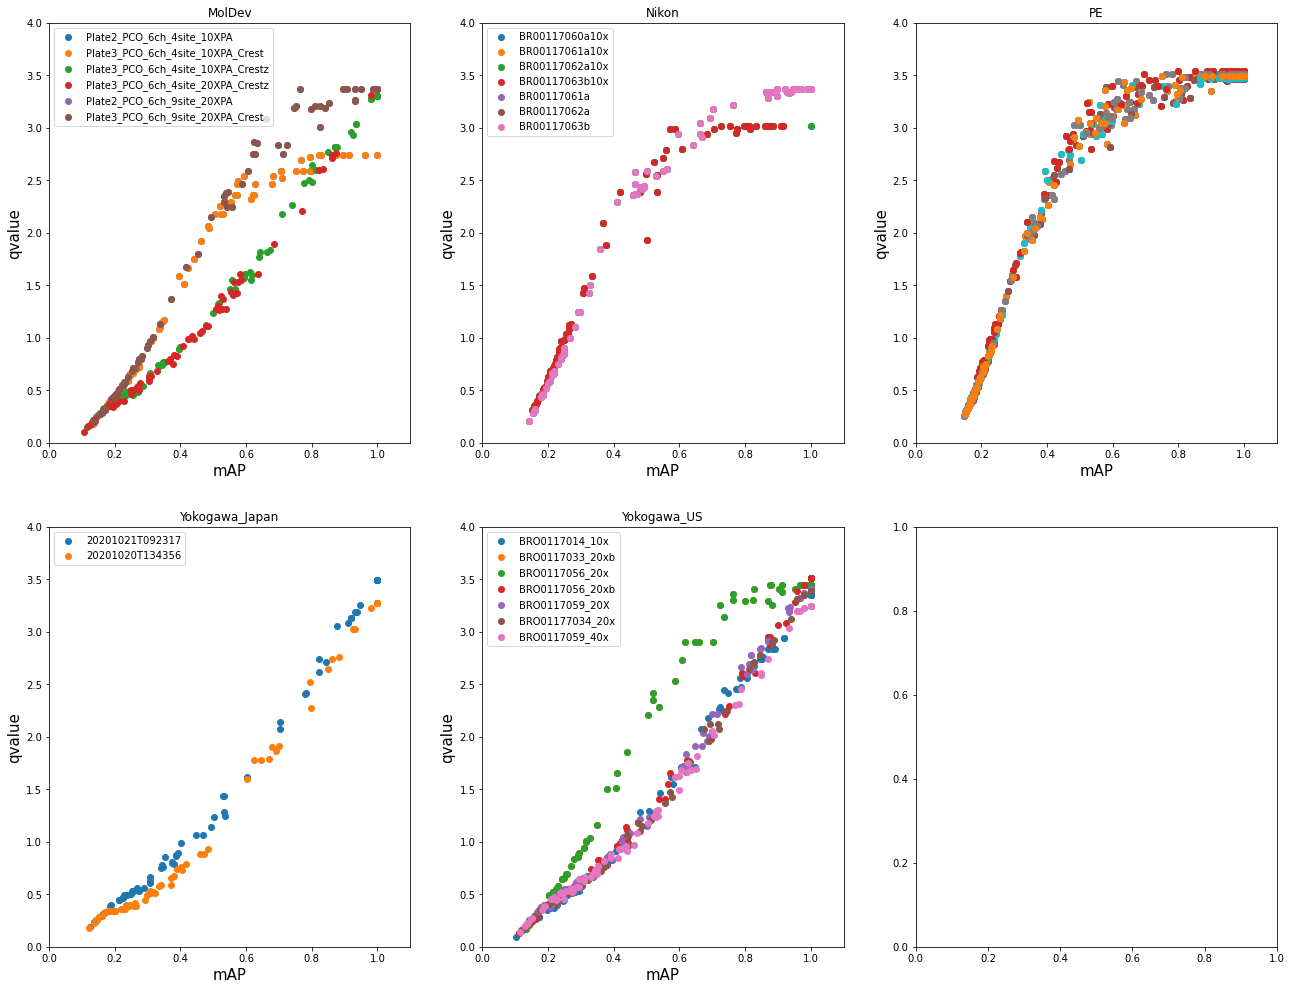

In [226]:
def plot_pval_ap_line(dataframe: pd.DataFrame, ref_non_rep: Literal["rep", "non_rep"] = "non_rep", ax = None, plot_proportion: bool = True, pval_threshold: float = 0.05):
    if ax is None:
        fig, ax = plt.subplots()

    x = dataframe["sim_retrieval_average_precision_i_mean_i"]
    y = dataframe["sim_retrieval_average_precision_i_nlog10qvalue_mean_i"]

    reg = np.poly1d(np.polyfit(x, y, 2))

    line = np.linspace(0, 1, 100)

    ax.scatter(x, y)
    # ax.plot(line, reg(line), c="orange")

    return ax



# Have an ax object to contain each of the lines
fig, ax = plt.subplots(2, 3, figsize=(22, 17))


# fig.suptitle("Fraction significant replicates mAP")
# fig.suptitle("Fraction significant matches mAP", fontsize=25)



for vend, _ax in zip(evalzoo_combined["Vendor"].unique(), ax.flatten()):
    _ax.set_xlim(0, 1.1)
    _ax.set_ylim(0, 4)
    _ax.set_xlabel("mAP", fontsize=15)
    _ax.set_ylabel("qvalue", fontsize=15)
    vendor_subset = evalzoo_combined[
        (evalzoo_combined["Vendor"] == vend) &
        (~evalzoo_combined["Batch"].str.contains("siteSub")) & 
        (evalzoo_combined["metric_type"] == "ref")
        # (evalzoo_combined["metric_type"] == "non_rep")
        ]
    _ax.set_title(vend)
    for batch, plate in vendor_subset[["Batch", "Metadata_Plate"]].drop_duplicates().values.tolist():
        plot_df = vendor_subset[
            (vendor_subset["Batch"] == batch) &
            (vendor_subset["Metadata_Plate"] == plate)
            ]

        plot_pval_ap_line(plot_df, ax=_ax)
    
    if "PE" not in vend:
        _ax.legend(vendor_subset["Metadata_Plate"].unique(), bbox_to_anchor=(0, 1), loc='upper left', ncol=1)



# ax.legend(vendor_subset["Metadata_Plate"].unique())

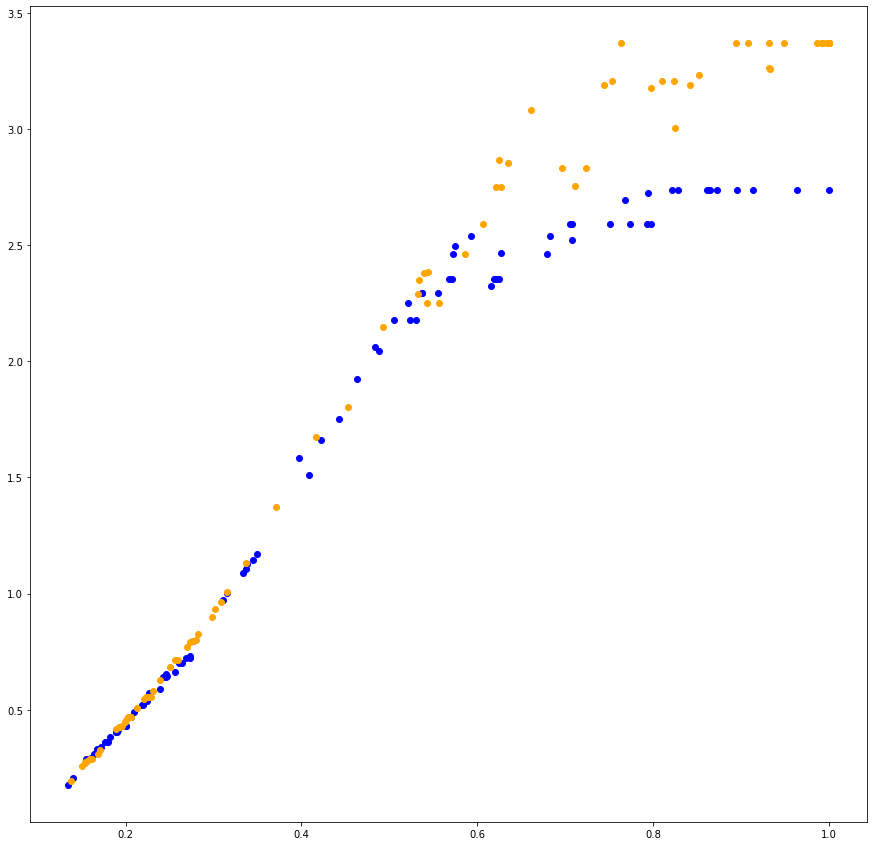

In [237]:
fig, ax = plt.subplots(figsize=(15,15))

t_df = evalzoo_combined[
    (evalzoo_combined["Vendor"] == "MolDev") &
    (evalzoo_combined["Metadata_Plate"].str.contains("Plate2_PCO_6ch_4site_10XPA")) &
    (~evalzoo_combined["Batch"].str.contains("siteSub")) & 
    (evalzoo_combined["metric_type"] == "ref")
    # (evalzoo_combined["metric_type"] == "non_rep")
    ]

# t_df = pd.read_parquet("/Users/ctromans/image-analysis/jump_scope/jump-scope-analysis/evalzoo/results/results/Scope1_MolDev_20X_9site_non_rep/metrics_level_1_ref.parquet")
# t_df = t_df.rename(lambda x: x.replace("_ref", "") if "sim_" in x else x, axis=1)

t_df2 = evalzoo_combined[
    (evalzoo_combined["Vendor"] == "MolDev") &
    (evalzoo_combined["Metadata_Plate"].str.contains("Plate3_PCO_6ch_9site_20XPA_Crest")) &
    (~evalzoo_combined["Batch"].str.contains("siteSub")) & 
    (evalzoo_combined["metric_type"] == "ref")
    # (evalzoo_combined["metric_type"] == "non_rep")
    ]

x = t_df["sim_retrieval_average_precision_i_mean_i"]
y = t_df["sim_retrieval_average_precision_i_nlog10qvalue_mean_i"]

x2 = t_df2["sim_retrieval_average_precision_i_mean_i"]
y2 = t_df2["sim_retrieval_average_precision_i_nlog10qvalue_mean_i"]

ax.scatter(x, y, c="blue")

ax.scatter(x2, y2, c="orange")

# ax.legend(t_df["Metadata_Plate"].unique())

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,15))

t_df = evalzoo_combined[
    (evalzoo_combined["Vendor"] == "MolDev") &
    (~evalzoo_combined["Batch"].str.contains("siteSub")) & 
    (evalzoo_combined["metric_type"] == "ref")
    # (evalzoo_combined["metric_type"] == "non_rep")
    ]



for plate in t_df["Metadata_Plate"].values:
    plot_df = t_df = evalzoo_combined[
        (evalzoo_combined["Vendor"] == "MolDev") &
        (~evalzoo_combined["Batch"].str.contains("siteSub")) & 
        (evalzoo_combined["metric_type"] == "ref")
        # (evalzoo_combined["metric_type"] == "non_rep")
        ]
    
    # x = plot_df["sim_retrieval_average_precision_i_mean_i"]
    # y = plot_df["sim_retrieval_average_precision_i_nlog10qvalue_mean_i"]
    # ax.scatter(x, y)

    g = sns.FacetGrid(plot_df, col="Metadata_Plate", col_wrap=3, sharey=False)
    g.map_dataframe(sns.scatterplot, x="sim_retrieval_average_precision_i_mean_i", y="sim_retrieval_average_precision_i_nlog10qvalue_mean_i")
    g.fig.subplots_adjust(top=0.9)
    # g.fig.suptitle(f"{pth.split('_')[0]}")

ax.legend(t_df["Metadata_Plate"].unique())

In [214]:
for i, j in t_df[["Batch", "Metadata_Plate"]].drop_duplicates().values.tolist():
    print(i, j)


Scope1_MolDev_10X Plate2_PCO_6ch_4site_10XPA
Scope1_MolDev_20X_9site Plate2_PCO_6ch_9site_20XPA


In [208]:
t_df

,Batch,Metadata_Plate,Metadata_pert_iname,Metadata_reference_or_other,sim_scaled_mean_i_mean_i,sim_scaled_mean_i_median_i,sim_scaled_median_i_mean_i,sim_scaled_median_i_median_i,sim_ranked_relrank_mean_i_mean_i,sim_ranked_relrank_mean_i_median_i,...,sim_retrieval_average_precision_i_mean_i,sim_retrieval_average_precision_i_median_i,sim_retrieval_r_precision_i_mean_i,sim_retrieval_r_precision_i_median_i,sim_retrieval_average_precision_i_nlog10pvalue_mean_i,sim_retrieval_average_precision_i_nlog10pvalue_median_i,sim_retrieval_average_precision_i_nlog10qvalue_mean_i,Vendor,metric_type,Metadata_moa
0,Scope1_MolDev_10X,Plate2_PCO_6ch_4site_10XPA,A-366,pert,0.017355,0.034813,-0.152331,-0.183784,0.505952,0.531250,...,0.164346,0.153485,0.107143,0.142857,0.333687,0.277463,0.308864,MolDev,ref,None
2,Scope1_MolDev_10X,Plate2_PCO_6ch_4site_10XPA,ABT-737,pert,1.550364,1.901986,1.559669,1.654185,0.158854,0.126488,...,0.554780,0.578962,0.428571,0.571429,2.727806,3.008908,2.293433,MolDev,ref,None
4,Scope1_MolDev_10X,Plate2_PCO_6ch_4site_10XPA,AMG-925,pert,2.544456,2.651249,2.358491,2.587136,0.101935,0.093750,...,0.707481,0.768701,0.589286,0.714286,3.290924,4.000043,2.591954,MolDev,ref,None
6,Scope1_MolDev_10X,Plate2_PCO_6ch_4site_10XPA,AMG900,pert,4.901146,6.038846,4.842577,6.131212,0.042411,0.025298,...,0.895064,0.975198,0.785714,0.857143,3.694733,4.000043,2.736706,MolDev,ref,None
8,Scope1_MolDev_10X,Plate2_PCO_6ch_4site_10XPA,APY0201,pert,5.183515,5.660523,4.608702,4.755717,0.037946,0.020833,...,0.913714,1.000000,0.857143,1.000000,3.823172,4.000043,2.736706,MolDev,ref,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,Scope1_MolDev_20X_9site,Plate2_PCO_6ch_9site_20XPA,selumetinib,pert,0.942691,1.022910,0.732095,0.552202,0.277902,0.252976,...,0.417016,0.404835,0.339286,0.357143,1.927340,1.760472,1.672067,MolDev,ref,None
712,Scope1_MolDev_20X_9site,Plate2_PCO_6ch_9site_20XPA,sirolimus,pert,3.217994,2.977883,3.025800,2.947361,0.033110,0.028274,...,0.931878,0.959439,0.821429,0.857143,4.000043,4.000043,3.368020,MolDev,ref,None
714,Scope1_MolDev_20X_9site,Plate2_PCO_6ch_9site_20XPA,skepinone-l,pert,1.617683,1.671776,1.698690,1.831329,0.145833,0.123512,...,0.627348,0.685861,0.517857,0.571429,3.126171,4.000043,2.751712,MolDev,ref,None
716,Scope1_MolDev_20X_9site,Plate2_PCO_6ch_9site_20XPA,valrubicin,pert,4.971464,4.886619,4.548754,4.560932,0.020833,0.020833,...,1.000000,1.000000,1.000000,1.000000,4.000043,4.000043,3.368020,MolDev,ref,None


<AxesSubplot:xlabel='Metadata_Plate', ylabel='sim_retrieval_average_precision_i_mean_i'>

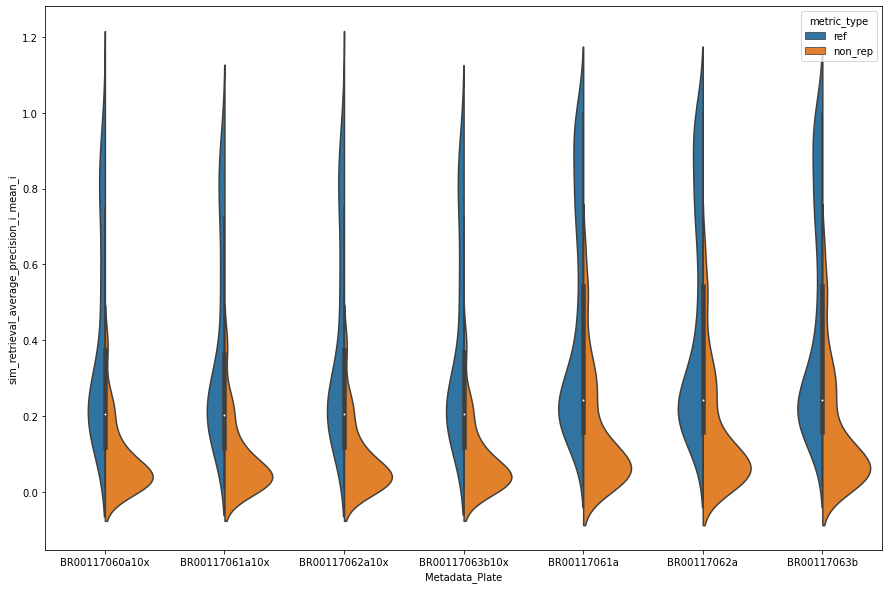

In [76]:
subset = evalzoo_combined[evalzoo_combined["Vendor"] == "Nikon"]

fig, ax = plt.subplots(figsize=(15, 10))

sns.violinplot(data=subset, x="Metadata_Plate", y="sim_retrieval_average_precision_i_mean_i", hue="metric_type", split=True, ax=ax)

<AxesSubplot:xlabel='Metadata_Plate', ylabel='sim_retrieval_average_precision_i_mean_i'>

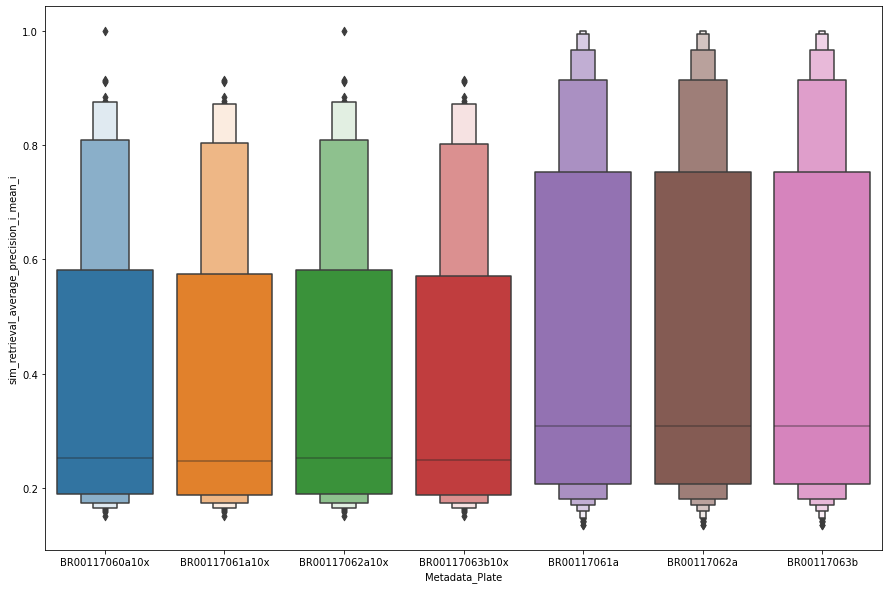

In [302]:
subset = evalzoo_combined[evalzoo_combined["Vendor"] == "Nikon"]

fig, ax = plt.subplots(figsize=(15, 10))

sns.boxenplot(data=subset[subset["metric_type"] == "ref"], x="Metadata_Plate", y="sim_retrieval_average_precision_i_mean_i", ax=ax)

[Text(0, 0, 'Plate2_PCO_6ch_4site_10XPA'),
 Text(1, 0, 'Plate3_PCO_6ch_4site_10XPA_Crest'),
 Text(2, 0, 'Plate3_PCO_6ch_4site_10XPA_Crestz'),
 Text(3, 0, 'Plate3_PCO_6ch_4site_20XPA_Crestz'),
 Text(4, 0, 'Plate2_PCO_6ch_9site_20XPA'),
 Text(5, 0, 'Plate3_PCO_6ch_9site_20XPA_Crest')]

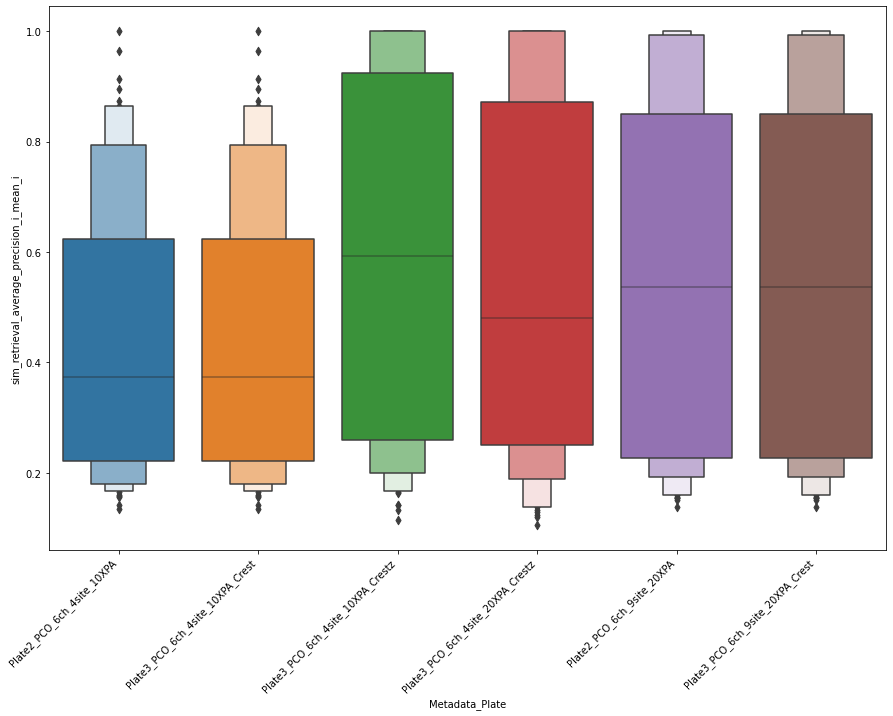

In [266]:
plot_df = evalzoo_combined[
    (evalzoo_combined["Vendor"] == "MolDev") &
    (~evalzoo_combined["Batch"].str.contains("siteSub")) & 
    (evalzoo_combined["metric_type"] == "ref")
    # (evalzoo_combined["metric_type"] == "non_rep")
    ]

fig, ax = plt.subplots(figsize=(15, 10))

sns.boxenplot(data=plot_df, x="Metadata_Plate", y="sim_retrieval_average_precision_i_mean_i", ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


[Text(0, 0, 'CP_Broad_Phenix_C_BIN1_1Plane_P1'),
 Text(1, 0, 'CP_Broad_Phenix_C_BIN1_1Plane_P2'),
 Text(2, 0, 'CP_Broad_Phenix_C_BIN1_1Plane_P3'),
 Text(3, 0, 'CP_Broad_Phenix_C_BIN1_1Plane_P4'),
 Text(4, 0, 'CP_Broad_Phenix_C_BIN1_P1'),
 Text(5, 0, 'CP_Broad_Phenix_C_BIN1_P2'),
 Text(6, 0, 'CP_Broad_Phenix_C_BIN1_P3'),
 Text(7, 0, 'CP_Broad_Phenix_C_BIN1_P4'),
 Text(8, 0, 'CP_Broad_Phenix_NC_BIN1_1Plane_P1'),
 Text(9, 0, 'CP_Broad_Phenix_NC_BIN1_1Plane_P2'),
 Text(10, 0, 'CP_Broad_Phenix_NC_BIN1_1Plane_P3'),
 Text(11, 0, 'CP_Broad_Phenix_NC_BIN1_1Plane_P4'),
 Text(12, 0, 'CP_Broad_Phenix_NC_BIN1_P1'),
 Text(13, 0, 'CP_Broad_Phenix_NC_BIN1_P2'),
 Text(14, 0, 'CP_Broad_Phenix_NC_BIN1_P3'),
 Text(15, 0, 'CP_Broad_Phenix_NC_BIN1_P4'),
 Text(16, 0, 'CPBroadPhenixC1PlaneP1'),
 Text(17, 0, 'CPBroadPhenixC1PlaneP2'),
 Text(18, 0, 'CPBroadPhenixC1PlaneP3'),
 Text(19, 0, 'CPBroadPhenixC1PlaneP4'),
 Text(20, 0, 'CPBroadPhenixCP1'),
 Text(21, 0, 'CPBroadPhenixCP2'),
 Text(22, 0, 'CPBroadPhenixCP3

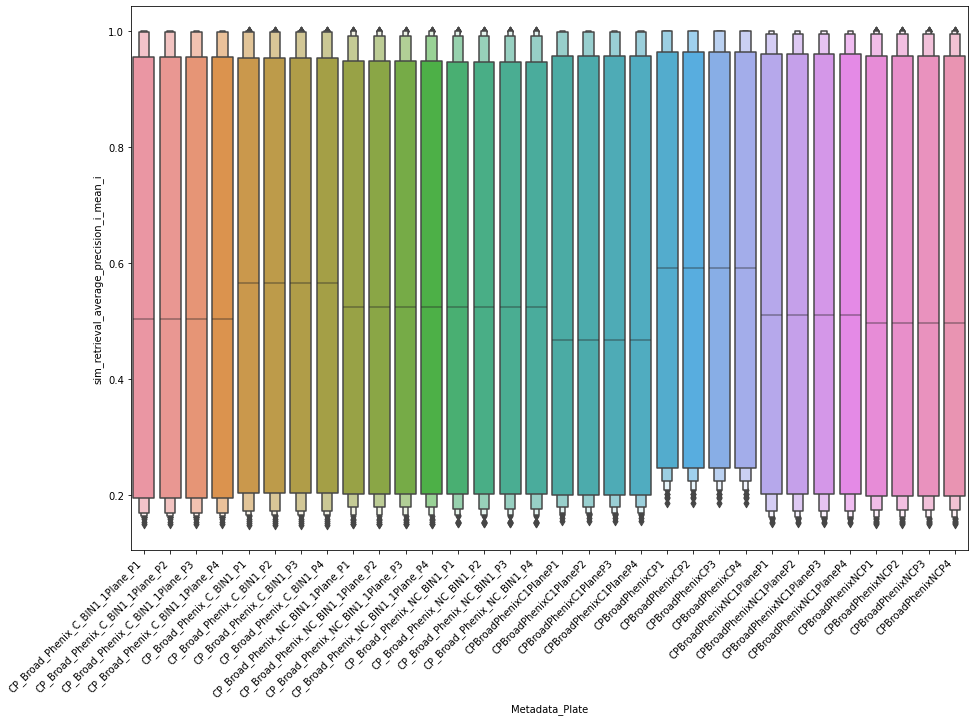

In [267]:
plot_df = evalzoo_combined[
    (evalzoo_combined["Vendor"] == "PE") &
    (~evalzoo_combined["Batch"].str.contains("siteSub")) & 
    (evalzoo_combined["metric_type"] == "ref")
    # (evalzoo_combined["metric_type"] == "non_rep")
    ]

fig, ax = plt.subplots(figsize=(15, 10))

sns.boxenplot(data=plot_df, x="Metadata_Plate", y="sim_retrieval_average_precision_i_mean_i", ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


In [268]:
evalzoo_combined.columns

Index(['Batch', 'Metadata_Plate', 'Metadata_pert_iname',
       'Metadata_reference_or_other', 'sim_scaled_mean_i_mean_i',
       'sim_scaled_mean_i_median_i', 'sim_scaled_median_i_mean_i',
       'sim_scaled_median_i_median_i', 'sim_ranked_relrank_mean_i_mean_i',
       'sim_ranked_relrank_mean_i_median_i',
       'sim_ranked_relrank_median_i_mean_i',
       'sim_ranked_relrank_median_i_median_i', 'sim_mean_i_mean_i',
       'sim_mean_i_median_i', 'sim_median_i_mean_i', 'sim_median_i_median_i',
       'sim_mean_stat_i_mean_i', 'sim_mean_stat_i_median_i',
       'sim_sd_stat_i_mean_i', 'sim_sd_stat_i_median_i',
       'sim_stat_signal_n_i_mean_i', 'sim_stat_signal_n_i_median_i',
       'sim_stat_background_n_i_mean_i', 'sim_stat_background_n_i_median_i',
       'sim_retrieval_average_precision_i_mean_i',
       'sim_retrieval_average_precision_i_median_i',
       'sim_retrieval_r_precision_i_mean_i',
       'sim_retrieval_r_precision_i_median_i',
       'sim_retrieval_average_precision

<AxesSubplot:xlabel='sim_retrieval_average_precision_i_mean_i', ylabel='Count'>

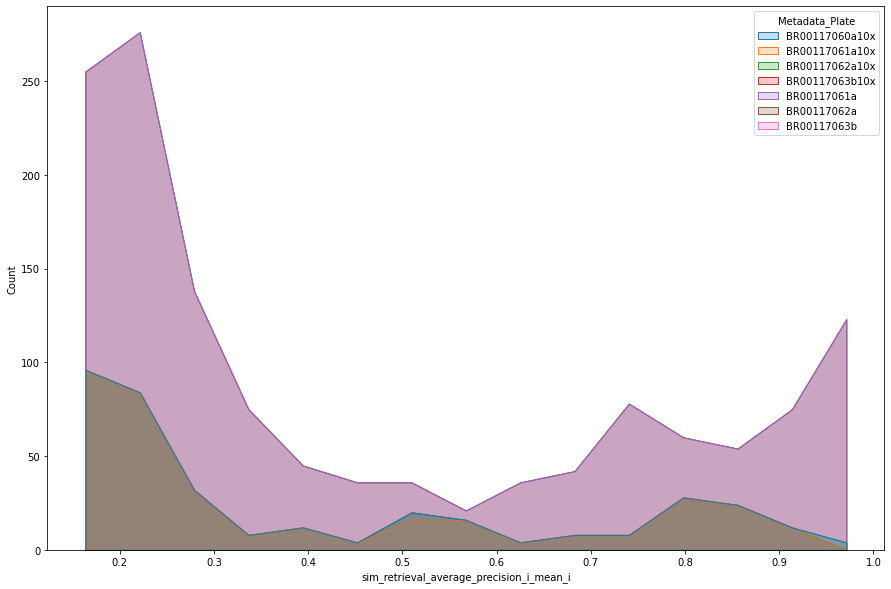

In [83]:
subset = evalzoo_combined[
        (evalzoo_combined["Vendor"] == "Nikon") 
        & (evalzoo_combined["metric_type"] == "ref")
]

fig, ax = plt.subplots(figsize=(15, 10))

# sns.violinplot(data=subset, x="Metadata_Plate", y="sim_retrieval_average_precision_i_mean_i", hue="metric_type", split=True, ax=ax)

sns.histplot(subset, x="sim_retrieval_average_precision_i_mean_i", hue="Metadata_Plate", element="poly", ax=ax)